# SRE ReAct agent with custom schema and RAG (to store mitigation plans)

This notebook implements an intelligent Site Reliability Engineering (SRE) agent that automatically diagnoses Kubernetes incidents and generates mitigation plans. The agent uses a ReAct (Reasoning + Acting) framework powered by LangGraph to:

- **Investigate incidents** using kubectl tools through MCP (Model Context Protocol) servers
- **Analyze cluster state** and extract meaningful insights from Kubernetes resources
- **Generate structured diagnosis** with detailed reasoning and root cause analysis
- **Create mitigation plans** by leveraging ChromaDB RAG to search for similar past incidents
- **Provide comprehensive reports** with step-by-step remediation guidance

In [2]:
from dotenv import load_dotenv
import os

# Set env variables from file
load_dotenv()

True

In [3]:
chromaDB_path = os.environ.get("CHROMADB_STORAGE_PATH")

## Testing the RAG (ChromaDB)

In [6]:
from chromadb import PersistentClient

chroma_client = PersistentClient(path=chromaDB_path)

incidents_collection = chroma_client.get_or_create_collection("incidents")

# Get all the docs in the collection
incidents_collection.peek()

{'ids': ['a27c328e-b573-4463-a2b3-9c1bc32d58e6',
  'e1613b61-063a-40de-a0e4-6b1c24d5f250'],
 'embeddings': array([[ 6.70451075e-02, -2.13284642e-02,  2.17653401e-02,
          4.55448925e-02, -5.73861506e-03, -4.59627621e-02,
          4.53623496e-02, -5.00395969e-02,  4.57851551e-02,
          3.29204798e-02, -1.09109385e-02, -8.50805193e-02,
         -2.46740822e-02, -1.22952955e-02,  4.03799005e-02,
         -2.45536007e-02,  5.99781200e-02, -7.49116857e-03,
         -3.27832364e-02, -2.38336436e-02,  3.29326130e-02,
          8.14366248e-03, -3.08141438e-03,  1.31960018e-02,
         -8.35228898e-03,  2.18658559e-02, -4.80365902e-02,
          1.19744232e-02,  1.32892309e-02, -6.18577525e-02,
         -7.54111446e-03,  4.97136936e-02,  1.84784289e-02,
          4.55506034e-02,  1.47869885e-01,  1.18755400e-01,
          7.92945269e-03, -6.49270192e-02, -4.15613241e-02,
          1.64432712e-02,  5.08863106e-03, -6.27124459e-02,
         -1.81484669e-02,  1.08183175e-03,  3.42151411

## Building SRE ReAct agent

In [4]:
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI

gpt5 = ChatOpenAI(model="gpt-5")
gpt5mini = ChatOpenAI(model="gpt-5-mini")
gemini = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    google_api_key=os.getenv("GOOGLEAI_API_KEY") # Google AI Studio free api key
)

In [ ]:
from langchain_mcp_adapters.client import MultiServerMCPClient

chromaDB_path = os.environ.get("CHROMADB_STORAGE_PATH")

prometheus_URL = os.environ.get("PROMETHEUS_SERVER_URL")

client = MultiServerMCPClient(
    {
        "kubernetes" : { # https://github.com/Flux159/mcp-server-kubernetes
            "command": "npx",
            "args": ["mcp-server-kubernetes"],
            "transport": "stdio",
            "env": {
                "ALLOW_ONLY_NON_DESTRUCTIVE_TOOLS": "true"
            }
        },
        "chroma": { # https://github.com/chroma-core/chroma-mcp
            "command": "uvx",
            "transport": "stdio",
            "args": [
                "chroma-mcp",
                "--client-type",
                "persistent",
                "--data-dir",
                str(chromaDB_path)
            ]
        },
        "prometheus": { # https://github.com/idanfishman/prometheus-mcp
            "command": "npx",
            "args": ["prometheus-mcp@latest", "stdio"],
            "transport": "stdio",
            "env": {
                "PROMETHEUS_URL": str(prometheus_URL)
            }
        }
    }
)

# NB: The cluster has to be running otherwise the tools won't be available
mcp_tools = await client.get_tools()

In [6]:
#list all the tools
for tool in mcp_tools:
    print(f"🔧 {tool.name}")

🔧 kubectl_get
🔧 kubectl_describe
🔧 kubectl_apply
🔧 kubectl_create
🔧 kubectl_logs
🔧 kubectl_scale
🔧 kubectl_patch
🔧 kubectl_rollout
🔧 kubectl_context
🔧 explain_resource
🔧 install_helm_chart
🔧 upgrade_helm_chart
🔧 port_forward
🔧 stop_port_forward
🔧 exec_in_pod
🔧 list_api_resources
🔧 ping
🔧 chroma_list_collections
🔧 chroma_create_collection
🔧 chroma_peek_collection
🔧 chroma_get_collection_info
🔧 chroma_get_collection_count
🔧 chroma_modify_collection
🔧 chroma_fork_collection
🔧 chroma_delete_collection
🔧 chroma_add_documents
🔧 chroma_query_documents
🔧 chroma_get_documents
🔧 chroma_update_documents
🔧 chroma_delete_documents
🔧 prometheus_list_metrics
🔧 prometheus_metric_metadata
🔧 prometheus_list_labels
🔧 prometheus_label_values
🔧 prometheus_list_targets
🔧 prometheus_scrape_pool_targets
🔧 prometheus_runtime_info
🔧 prometheus_build_info
🔧 prometheus_query
🔧 prometheus_query_range


In [7]:
# Tools allowed
tools_allowed = ["kubectl_get", "kubectl_describe", "kubectl_logs", "explain_resource", "list_api_resources", "ping"]

k8s_tools = []
chroma_tools = []
prometheus_tools = []

for tool in mcp_tools:
    # Remove not allowed MCP tools
    if tool.name in tools_allowed:
        k8s_tools.append(tool)
    # Create a custom list for ChromaDB tools
    elif "chroma" in  tool.name:
        chroma_tools.append(tool)
    # Create a custom list of Prometheus tools
    elif "prometheus" in tool.name:
        prometheus_tools.append(tool)
    

In [8]:
# List of kubernetes tools
for tool in k8s_tools:
    print(f"🔧 {tool.name}: {tool.description}")

🔧 kubectl_get: Get or list Kubernetes resources by resource type, name, and optionally namespace
🔧 kubectl_describe: Describe Kubernetes resources by resource type, name, and optionally namespace
🔧 kubectl_logs: Get logs from Kubernetes resources like pods, deployments, or jobs
🔧 explain_resource: Get documentation for a Kubernetes resource or field
🔧 list_api_resources: List the API resources available in the cluster
🔧 ping: Verify that the counterpart is still responsive and the connection is alive.


In [9]:
# List of chromaDB tools
for tool in chroma_tools:
    print(f"🔧 {tool.name}")

🔧 chroma_list_collections
🔧 chroma_create_collection
🔧 chroma_peek_collection
🔧 chroma_get_collection_info
🔧 chroma_get_collection_count
🔧 chroma_modify_collection
🔧 chroma_fork_collection
🔧 chroma_delete_collection
🔧 chroma_add_documents
🔧 chroma_query_documents
🔧 chroma_get_documents
🔧 chroma_update_documents
🔧 chroma_delete_documents


In [10]:
# List of prometheus tools
for tool in prometheus_tools:
    print(f"🔧 {tool.name} : {tool.description}")

🔧 prometheus_list_metrics : List all available Prometheus metrics
🔧 prometheus_metric_metadata : Get metadata for a specific Prometheus metric
🔧 prometheus_list_labels : List all available Prometheus labels
🔧 prometheus_label_values : Get all values for a specific Prometheus label
🔧 prometheus_list_targets : List all Prometheus targets
🔧 prometheus_scrape_pool_targets : Get targets for a specific scrape pool
🔧 prometheus_runtime_info : Get Prometheus runtime information
🔧 prometheus_build_info : Get Prometheus build information
🔧 prometheus_query : Execute a Prometheus query
🔧 prometheus_query_range : Execute a Prometheus range query


In [ ]:
from typing import TypedDict, List, Literal, Annotated
from langgraph.graph.message import add_messages, AnyMessage
import operator

class SREAgentState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    app_summary: str
    insights: Annotated[list[str], operator.add]
    prev_steps: Annotated[list[str], operator.add]
    response: str
    final_output: str
    mitigation_plan_overview: str
    mitigation_steps: List[str]
    has_already_happened: bool

In [12]:
sre_agent_prompt = """
    You are an expert DevOps engineer who has been tasked with detecting anomalies in a deployed service.

    The service you are working with today is described below:
    {app_summary}

    You will use an MCP server which will provide you access to the Kubernetes cluster and prometheus server.

    Context:

    *Previous Steps:*
    {prev_steps}

    *Insights:*
    {insights}

    Your task:
        1. Begin by analyzing the service's state and telemetry using kubectl and prometheus tools
        2. When you have identified the issue, call the submit_final_diagnosis tool with:
            - diagnosis: Describe the issue you have identified (without fixing it)
            - reasoning: Explain your reasoning and thought process behind the solution

    IMPORTANT: You must call submit_final_diagnosis when you're ready to conclude your investigation.
"""

In [13]:
summarise_prompt = """
    You are an autonomous SRE agent for Kubernetes incident diagnosis.

    Context:

    Previous Insights: 
    {insights}
    
    Previous Steps:
    {prev_steps}

    Below are the latest two messages:
    {last_two_messages}

    Instructions:
    1. From the latest two messages, extract the most important new insight relevant for incident diagnosis or mitigation. Summarize it concisely.
    2. Write a concise description of only the most recent action taken including the tool used (not the whole list).  
"""

In [14]:
def get_insights_str(state):
    """Return a string with the formatted list of insights gathered during exploration"""
    if len(state["insights"]) > 0:
        return "\n- ".join([""] + state["insights"])
    else:
        return "No insights yet"
    
def get_prev_steps_str(state):
    """Return a string with the formatted list of previous steps performed during exploration"""
    if len(state["prev_steps"]) > 0:
        return "\n- ".join([""] + state["prev_steps"])
    else:
        return "No previous steps yet"

### Extract insights node

In [15]:
from pydantic import BaseModel, Field

class UpdateAgentData(BaseModel):
    """
    Represents a step performed by the SRE agent.
    """
    insight: str = Field(..., description="Most important new finding")
    prev_step: str = Field(..., description="Concise description of the most recent action taken")

In [16]:
llm_with_struct_output = gpt5mini.with_structured_output(UpdateAgentData)

In [17]:
from langchain_core.messages import HumanMessage

# Node used to summarise the infos given the two previous messages
async def summarise(state: SREAgentState):

    # Gather last two messages (tool call + tool response)
    last_messages = state["messages"][-2:]

    insights_str = get_insights_str(state)
    prev_step_str = get_prev_steps_str(state)

    prompt = HumanMessage(content=summarise_prompt.format(
        prev_steps = prev_step_str,
        insights=insights_str,
        last_two_messages=last_messages))

    data = llm_with_struct_output.invoke([prompt])

    return {"insights" : [data.insight], "prev_steps" : [data.prev_step]}

### SRE Agent node

In [18]:
from typing import Annotated
from langgraph.types import Command
from langchain_core.messages import ToolMessage
from langchain_core.tools import tool, InjectedToolCallId

# Tool used to submit the final response
@tool
def submit_final_diagnosis(
    diagnosis: str, 
    reasoning: str,
    tool_call_id: Annotated[str, InjectedToolCallId]
) -> Command:
    """
    Submit the final diagnosis when investigation is complete.
    
    Args:
        diagnosis: The issue you have identified (without fixing it)
        reasoning: Your reasoning and thought process behind the diagnosis
    
    Returns:
        Command to update state and end workflow
    """
    final_response = f"Diagnosis:\n{diagnosis}\n\nReasoning:\n{reasoning}"
    
    return Command(
        update={
            "response": final_response, # Add in the final graph state the final answer
            "messages": [
                ToolMessage(
                    content="Final diagnosis submitted successfully. Investigation complete.",
                    tool_call_id=tool_call_id
                )
            ]
        },
        goto="format-output" # End the loop cycle
    )

# Append the tool for submission to the list of tools (MCP servers)
completion_tool = submit_final_diagnosis
sre_agent_tools = k8s_tools + prometheus_tools + [completion_tool]

In [19]:
async def sreAgent(state: SREAgentState):

    insights_str = get_insights_str(state)
    prev_step_str = get_prev_steps_str(state)

    prompt = HumanMessage(content=sre_agent_prompt.format(
        prev_steps=prev_step_str, 
        insights=insights_str, 
        app_summary=state["app_summary"]
    ))

    # Use tools with completion (for the submission)
    llm_with_completion_tools = gpt5mini.bind_tools(sre_agent_tools, parallel_tool_calls=False)
    return {"messages": [llm_with_completion_tools.invoke([prompt])]}

In [20]:
sre_agent_tools

[StructuredTool(name='kubectl_get', description='Get or list Kubernetes resources by resource type, name, and optionally namespace', args_schema={'type': 'object', 'properties': {'resourceType': {'type': 'string', 'description': 'Type of resource to get (e.g., pods, deployments, services, configmaps, events, etc.)'}, 'name': {'type': 'string', 'description': 'Name of the resource (optional - if not provided, lists all resources of the specified type)'}, 'namespace': {'type': 'string', 'description': 'Kubernetes namespace', 'default': 'default'}, 'output': {'type': 'string', 'enum': ['json', 'yaml', 'wide', 'name', 'custom'], 'description': 'Output format', 'default': 'json'}, 'allNamespaces': {'type': 'boolean', 'description': 'If true, list resources across all namespaces', 'default': False}, 'labelSelector': {'type': 'string', 'description': "Filter resources by label selector (e.g. 'app=nginx')"}, 'fieldSelector': {'type': 'string', 'description': "Filter resources by field selector

In [21]:
async def format_response(state: SREAgentState):
    insights_str = get_insights_str(state)
    prev_step_str = get_prev_steps_str(state)

    message = "# 📝 Results of the Analysis\n\n"

    # Steps performed
    message += "## 🔍 Steps Performed\n"
    message += prev_step_str.strip() + "\n\n"

    # Insights
    message += "## 💡 Insights Gathered\n"
    message += insights_str.strip() + "\n\n"

    # Final root cause
    message += "## 🚨 Final Report (Root Cause)\n"
    message += f"> {state['response'].strip()}\n\n"

    # Mitigation overview
    message += "## 🛠️ Mitigation Plan Strategy\n"
    message += f"{state['mitigation_plan_overview'].strip()}\n\n"

    # Detailed mitigation steps
    message += "## 📋 Detailed Mitigation Steps\n"
    for i, step in enumerate(state["mitigation_steps"], start=1):
        message += f"{i}. {step}\n"

    return {"final_output": message}


### Elaborate mitigation plan

In [22]:
class MitigationPlanResponse(BaseModel):
    mitigation_steps: List[str] = Field(..., description="List of steps to be executed to mitigate the current incident")
    mitigation_plan_overview: str = Field(..., description="Short overview of the mitigation plan to be executed")
    is_previous_incident: bool = Field(..., description="True if the mitigation plan was found in the incidetns colletionc (incident already happened)")

In [23]:
mitigation_planner_prompt = """
    You're a React agent developed using the LangGraph prebuilt agent framework, in charge of creating a mitigation plan to solve an incident in a deployed Kubernetes infrastructure.
    
    Important: do not execute the mitigation plan, just explain all the steps.

    The root cause will be provided and then you should:
        1. Look using the ChromaDB tools if you find any similar incident in the 'incidents' collection.
        2. If so, set "is_previous_incident" to True and return the mitigation plan previously discovered if it fits for the current problem.
        3. If not, create a custom mitigation plan. Use Kubernetes tools only to check for more information, but try to avoid using them unless necessary.
    
    Report of the incident:
    {incident_report}
"""

In [24]:
mitigation_agent_tools = k8s_tools + chroma_tools
mitigation_agent_tools

[StructuredTool(name='kubectl_get', description='Get or list Kubernetes resources by resource type, name, and optionally namespace', args_schema={'type': 'object', 'properties': {'resourceType': {'type': 'string', 'description': 'Type of resource to get (e.g., pods, deployments, services, configmaps, events, etc.)'}, 'name': {'type': 'string', 'description': 'Name of the resource (optional - if not provided, lists all resources of the specified type)'}, 'namespace': {'type': 'string', 'description': 'Kubernetes namespace', 'default': 'default'}, 'output': {'type': 'string', 'enum': ['json', 'yaml', 'wide', 'name', 'custom'], 'description': 'Output format', 'default': 'json'}, 'allNamespaces': {'type': 'boolean', 'description': 'If true, list resources across all namespaces', 'default': False}, 'labelSelector': {'type': 'string', 'description': "Filter resources by label selector (e.g. 'app=nginx')"}, 'fieldSelector': {'type': 'string', 'description': "Filter resources by field selector

In [ ]:
from langgraph.prebuilt import create_react_agent

async def mitigation_planner(state: SREAgentState):

    # Create a React agent
    mitigation_agent = create_react_agent(
        name = "MitigationPlanGenerator",
        model = gpt5mini,
        tools = mitigation_agent_tools,
        prompt= mitigation_planner_prompt.format(incident_report = state["response"]),
        response_format = MitigationPlanResponse
    )

    mitigation_response = await mitigation_agent.ainvoke({})

    return {
        "mitigation_plan_overview" : mitigation_response['structured_response'].mitigation_plan_overview,
        "mitigation_steps" : mitigation_response['structured_response'].mitigation_steps,
        "has_already_happened" : mitigation_response['structured_response'].is_previous_incident
    }

In [26]:
async def store_incident_report(state: SREAgentState):
    """Store the incident report with the mitigation plan in chromaDB incidents collection"""

    from chromadb import PersistentClient
    import uuid

    chroma_client = PersistentClient(path=chromaDB_path)

    incidents_collection = chroma_client.get_or_create_collection("incidents")

    incidents_collection.add(
        ids=[str(uuid.uuid4())],
        documents=state["final_output"],
    )

    return {}

### Assemble the graph

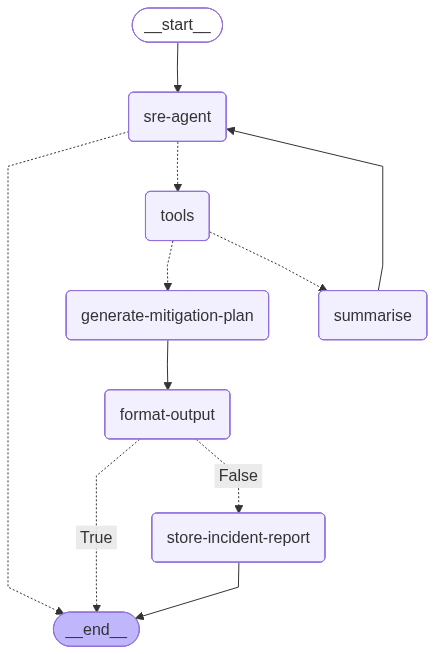

In [ ]:
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

# Build the graph
builder = StateGraph(SREAgentState)

# Add nodes
builder.add_node("sre-agent", sreAgent)
builder.add_node("tools", ToolNode(sre_agent_tools)) # Tool node is executing the tool called in the previous message
builder.add_node("summarise", summarise) # Node to reduce the raw data into a schema
builder.add_node("generate-mitigation-plan", mitigation_planner)
builder.add_node("format-output", format_response)
builder.add_node("store-incident-report", store_incident_report)

# Add edges
builder.add_edge(START, "sre-agent")

# Conditional edge from sre-agent
builder.add_conditional_edges(
    "sre-agent",
    #Use in the conditional_edge to route to the ToolNode if the last message has tool calls. Otherwise, route to the end.
    tools_condition,
)

# After tools, decide whether to summarise or end
def after_tools_condition(state: SREAgentState):
    # If response is filled, investigation is complete (end of the workflow)
    if state.get("response"):
        return "generate-mitigation-plan"
    return "summarise"

builder.add_conditional_edges(
    "tools",
    after_tools_condition,
    {
        "summarise": "summarise",
        "generate-mitigation-plan": "generate-mitigation-plan"
    }
)

# If is a new incident, store in VectorDB
def has_already_happened(state: SREAgentState):
    return bool(state['has_already_happened'])
    
builder.add_conditional_edges(
    "format-output",
    has_already_happened,
    {
        True: END,
        False: "store-incident-report"
    }
)

# After summarise, continue investigation (go to sre-agent)
builder.add_edge("summarise", "sre-agent")
builder.add_edge("generate-mitigation-plan", "format-output")
builder.add_edge("format-output", END)
builder.add_edge("store-incident-report", END)

# Compile the graph
structured_graph = builder.compile()

# Show the graph
display(Image(structured_graph.get_graph(xray=True).draw_mermaid_png()))

In [28]:
print(structured_graph.get_graph(xray=True).draw_mermaid())

---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	sre-agent(sre-agent)
	tools(tools)
	summarise(summarise)
	generate-mitigation-plan(generate-mitigation-plan)
	format-output(format-output)
	store-incident-report(store-incident-report)
	__end__([<p>__end__</p>]):::last
	__start__ --> sre-agent;
	format-output -. &nbsp;True&nbsp; .-> __end__;
	format-output -. &nbsp;False&nbsp; .-> store-incident-report;
	generate-mitigation-plan --> format-output;
	sre-agent -.-> __end__;
	sre-agent -.-> tools;
	summarise --> sre-agent;
	tools -.-> generate-mitigation-plan;
	tools -.-> summarise;
	store-incident-report --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



In [29]:
from datetime import datetime

def save_markdown_file(structured_result, trace_name):
    
    # Get the output path from environment variable
    output_path = os.getenv("RESULTS_PATH")
    if not output_path:
        raise ValueError("Environment variable not set")
    

    # Generate timestamp for filename and title
    now = datetime.now()
    filename_timestamp = now.strftime("%Y-%m-%d_%H-%M-%S")
    title_timestamp = now.strftime("%Y-%m-%d %H:%M:%S")
    
    # Create filename
    filename = f"{filename_timestamp}.md"
    filepath = output_path + "/" + filename
    
    # Get markdown content
    markdown_content = structured_result.get("final_output", "")
    
    # Create the complete file content with title header
    file_content = f"""# {title_timestamp} - {trace_name}

    {markdown_content}"""
    
    # Write to file
    with open(filepath, 'w', encoding='utf-8') as f:
        f.write(file_content)
    
    print(f"Markdown file saved: {filepath}")
    return str(filepath)

In [ ]:
import time

async def test_structured_graph(graph, app_summary:str, human_message: str = "", trace_name: str = None):
    """Test the structured graph with SREAgentState"""
    # Create initial state with SREAgentState structure
    initial_state = {
        "messages": [HumanMessage(content=human_message)] if human_message else [],
        "insights": [],
        "prev_steps": [],
        "response": "",
        "final_output" : "",
        "app_summary" : app_summary,
        "mitigation_plan_overview" : "",
        "mitigation_steps" : [],
        "has_already_happened" : False
    }
    
    # Start time tracking
    start_time = time.time()

    # Configuration for the graph execution
    config = {"recursion_limit": 50}
    if trace_name:
        config["run_name"] = trace_name
    
    # Invoke the graph asynchronously
    result = await graph.ainvoke(initial_state, config)

    # Calculate execution time
    execution_time = time.time() - start_time

    save_markdown_file(result, trace_name)

    return result

In [31]:
experiment_name = input("Enter experiment name: ")

if experiment_name.strip() == "":
    experiment_name = "SRE structured format agent"

In [32]:
app_summary = """
    The application implements a hotel reservation service, build with Go and gRPC, and starting from the open-source project https://github.com/harlow/go-micro-services. The initial project is extended in several ways, including adding back-end in-memory and persistent databases, adding a recommender system for obtaining hotel recommendations, and adding the functionality to place a hotel reservation. 
"""

In [33]:
human = ""
structured_result = await test_structured_graph(structured_graph, app_summary, human, experiment_name)

Markdown file saved: /Users/martinimarcello00/github-sync/SRE-agent/results/2025-09-02_09-18-35.md


In [34]:
from IPython.display import Markdown, display

display(Markdown(structured_result["final_output"]))

# 📝 Results of the Analysis

## 🔍 Steps Performed
- Used kubectl_get to run 'kubectl get pods --all-namespaces -o wide' to inspect pod statuses.
- Used kubectl_describe on pod 'geo' in namespace 'test-hotel-reservation'.
- Ran kubectl_describe on pod 'geo' in namespace 'test-hotel-reservation' to inspect container state and events.
- Ran kubectl_get (kubectl get pods -n test-hotel-reservation -o wide) to list pods and confirm the geo pod's CrashLoopBackOff status and restart count.
- Ran kubectl_logs on pod geo-6b4b89b5f5-qnznd in namespace test-hotel-reservation (tail 200) to retrieve recent container logs.
- Ran kubectl_get (kubectl get pods -n test-hotel-reservation -o wide) to list pods and verify statuses.

## 💡 Insights Gathered
- Pod test-hotel-reservation/geo is in CrashLoopBackOff (0/1) with 9 restarts — likely the primary cause of failures in the test-hotel-reservation application.
- Pod geo (container hotel-reserv-geo) is in CrashLoopBackOff with RestartCount 9 and LastState Terminated (Exit Code 2). Image pulls succeed, so the app process is failing on startup (application error) rather than an image/pull or node issue.
- Container 'hotel-reserv-geo' in pod geo-6b4b89b5f5-qnznd repeatedly crashes on startup with Exit Code 2 (last run lasted ~11s), producing CrashLoopBackOff despite successful image pulls — indicates an application-level startup failure rather than image/node issues.
- The geo pod (test-hotel-reservation/geo) is confirmed in CrashLoopBackOff with 9 restarts (last event ~73s ago) while all other application pods are Running — the failure is isolated to the geo pod.
- The geo container is panicking during startup because it cannot connect to MongoDB at mongodb-geo:27777 (log: "no reachable servers"), causing the CrashLoopBackOff.
- The mongodb-geo pod is Running (1/1) at 10.244.1.14 — the MongoDB instance for the geo service is up, so the geo container’s “no reachable servers” crash is likely due to connection configuration (hostname/port/service/DNS/network) rather than the DB pod being down.

## 🚨 Final Report (Root Cause)
> Diagnosis:
The geo service container is crashing on startup because it cannot connect to the MongoDB instance: the geo app is attempting to reach mongodb-geo:27777 and reports “no reachable servers”, which causes a panic and exit (Exit Code 2) and leads to CrashLoopBackOff.

Reasoning:
Investigation summary and reasoning:
- The geo pod (test-hotel-reservation/geo) is in CrashLoopBackOff with RestartCount 9 and LastState Terminated (Exit Code 2), indicating the application process fails on startup rather than an image/node issue.
- Container logs from the geo pod show an application panic during startup with the message that it cannot connect to MongoDB at mongodb-geo:27777 (error: "no reachable servers").
- The mongodb-geo pod is Running (10.244.1.14), so the database server process exists and the pod is up; image pulls and pod scheduling are not the problem.
- The combination of the geo process dying with a MongoDB connection error and a running mongodb pod strongly suggests a connection configuration issue (wrong hostname, wrong port, or service/endpoint mismatch) rather than MongoDB being down.
- The explicit port in the geo logs (27777) is suspicious because MongoDB commonly listens on 27017; this indicates the geo service is likely configured with the wrong port (or the mongodb service exposes a different port), causing the driver to be unable to reach a MongoDB endpoint and crash on startup.

Therefore the root cause is an application-level misconfiguration: the geo service cannot reach MongoDB at the configured address (mongodb-geo:27777), causing the service to panic and repeatedly crash.

## 🛠️ Mitigation Plan Strategy
The geo pod is crashing because it attempts to connect to mongodb-geo:27777 while the MongoDB Service listens on port 27017. The safe fix is to update the geo configuration to use port 27017 and rollout the deployment. As a short-term emergency workaround (if changing the app config is not immediately possible), you may temporarily patch the mongodb-geo Service to expose 27777, but this has risk and must be reverted after the app config is fixed. Verify rollout, logs, connectivity, and add follow-up preventive measures.

## 📋 Detailed Mitigation Steps
1. Confirm current state (read-only): kubectl -n test-hotel-reservation get pods -o wide; kubectl -n test-hotel-reservation describe pod <geo-pod-full-name>; kubectl -n test-hotel-reservation logs <geo-pod-full-name> -c <container-name> --tail=200 (use --previous if needed).
2. Inspect mongodb-geo Service and endpoints: kubectl -n test-hotel-reservation get svc mongodb-geo -o yaml; kubectl -n test-hotel-reservation get endpoints mongodb-geo -o yaml; kubectl -n test-hotel-reservation get pods -l app=mongodb-geo -o wide.
3. Find where port 27777 is configured for geo: kubectl -n test-hotel-reservation get deploy geo -o yaml | grep -n "27777" || true; kubectl -n test-hotel-reservation get configmap -o yaml | grep -n "27777" || true; kubectl -n test-hotel-reservation get secret -o yaml | grep -n "27777" || true; inspect Helm values if applicable.
4. Recommended fix (safe): update geo configuration to use port 27017. If an env var: kubectl -n test-hotel-reservation set env deployment/geo MONGO_PORT=27017 or kubectl -n test-hotel-reservation edit deployment geo and change 27777 → 27017. If in a ConfigMap, edit it and then restart the deployment: kubectl -n test-hotel-reservation rollout restart deployment geo.
5. If using Helm, update values.yaml with correct port and helm upgrade: helm -n test-hotel-reservation upgrade <release> <chart> -f values.yaml.
6. Verify rollout & recovery: kubectl -n test-hotel-reservation rollout status deployment/geo; kubectl -n test-hotel-reservation get pods -l app=geo -o wide; kubectl -n test-hotel-reservation logs <new-geo-pod> -c <container-name> --tail=200 — confirm successful DB init and no panic.
7. Optional connectivity debug: kubectl -n test-hotel-reservation run --rm -it debug-net --image=nicolaka/netshoot --restart=Never -- /bin/bash; inside: nc -vz mongodb-geo 27017 or use a mongo client to verify connectivity.
8. Temporary emergency workaround (only if you cannot change geo config immediately): patch the mongodb-geo Service to expose 27777 (temporary). Either change the service port to 27777 via kubectl patch or add an additional port entry mapping 27777 → targetPort 27017. Immediately monitor geo logs and revert once permanent fix is applied.
9. If remediation causes regressions: rollback the geo deployment (kubectl -n test-hotel-reservation rollout undo deployment geo) and/or revert the Service patch via kubectl edit svc mongodb-geo.
10. If issue persists, collect diagnostics: kubectl -n test-hotel-reservation logs <geo-pod> --previous -c <container-name>; kubectl -n test-hotel-reservation describe pod <geo-pod>; kubectl -n test-hotel-reservation get events --sort-by='.lastTimestamp'; capture YAML snapshots of Deployment/ConfigMap/Service for analysis.
11. Post-remediation validation & cleanup: ensure geo pod is Running and Ready without CrashLoopBackOff; run application-level smoke tests exercising geo DB flows; remove any temporary Service patches.
12. Follow-up actions to prevent recurrence: centralize DB connection config in a single ConfigMap/Secret or Helm value; add startup retry/backoff and non-fatal DB connection handling in the geo app; add CI checks to validate host:port connectivity in staging; add alerting for CrashLoopBackOff with log context indicating DB connection failures; commit corrected config to version control/Helm charts.


## Analysis of the experiment

In [35]:
from langchain_core.messages import AIMessage

for i, msg in enumerate(structured_result['messages']):
    if isinstance(msg, AIMessage):
        print(f'{i}) {msg.additional_kwargs["tool_calls"][0]["function"]["name"]}') 

0) kubectl_get
2) kubectl_describe
4) kubectl_describe
6) kubectl_get
8) kubectl_logs
10) kubectl_get
12) submit_final_diagnosis


In [37]:
structured_result['messages'][12].additional_kwargs["tool_calls"][0]

{'id': 'call_xED0KnCmnyfYVR1psWTSN4mZ',
 'function': {'arguments': '{"diagnosis":"The geo service container is crashing on startup because it cannot connect to the MongoDB instance: the geo app is attempting to reach mongodb-geo:27777 and reports “no reachable servers”, which causes a panic and exit (Exit Code 2) and leads to CrashLoopBackOff.","reasoning":"Investigation summary and reasoning:\\n- The geo pod (test-hotel-reservation/geo) is in CrashLoopBackOff with RestartCount 9 and LastState Terminated (Exit Code 2), indicating the application process fails on startup rather than an image/node issue.\\n- Container logs from the geo pod show an application panic during startup with the message that it cannot connect to MongoDB at mongodb-geo:27777 (error: \\"no reachable servers\\").\\n- The mongodb-geo pod is Running (10.244.1.14), so the database server process exists and the pod is up; image pulls and pod scheduling are not the problem.\\n- The combination of the geo process dying 

In [38]:
from langchain_core.messages import AIMessage
import matplotlib.pyplot as plt
from collections import Counter

def count_tool_calls(messages):
    """
    Plots a bar chart of tool call occurrences by tool name from state['messages'].
    """
    # Extract tool names from ToolMessage objects
    tool_calls = []
    for msg in messages:

        if isinstance(msg, AIMessage):
            if hasattr(msg, 'additional_kwargs'):
                if "tool_calls" in msg.additional_kwargs:
                    for call in msg.additional_kwargs['tool_calls']:
                        if "function" in call:
                            if "name" in call["function"]:
                                tool_calls.append(call["function"]["name"])

    # Count occurrences
    counts = Counter(tool_calls)

    return dict(counts)

In [39]:
tool_calls = count_tool_calls(structured_result["messages"])
tool_calls

{'kubectl_get': 3,
 'kubectl_describe': 2,
 'kubectl_logs': 1,
 'submit_final_diagnosis': 1}

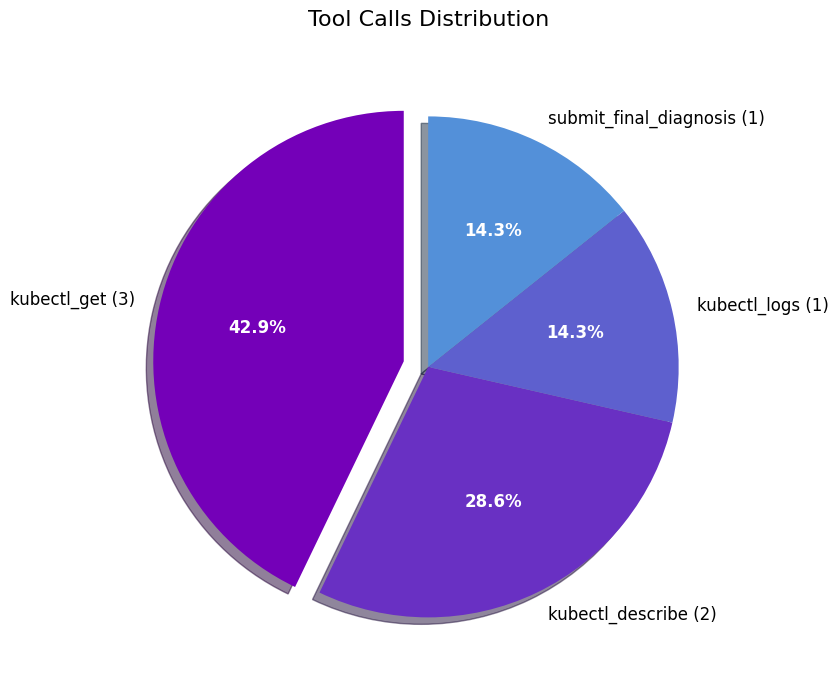

In [40]:
import matplotlib.pyplot as plt

# Create a better color palette with purple shades
colors = ['#7400B8', '#6930C3', '#5E60CE', '#5390D9', '#4EA8DE', '#48BFE3'][:len(tool_calls)]
# Create labels with tool name and count
labels = [f"{tool} ({count})" for tool, count in tool_calls.items()]

# Create an explode effect for the largest value
values = list(tool_calls.values())
explode = [0.1 if v == max(values) else 0 for v in values]

# Create the pie chart with improvements
fig, ax = plt.subplots(figsize=(10, 7))
wedges, texts, autotexts = ax.pie(
    values, 
    explode=explode,
    labels=labels, 
    colors=colors,
    autopct='%1.1f%%',
    shadow=True,
    startangle=90,
    textprops={'fontsize': 12}
)

# Make the percentage text more visible
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

plt.title('Tool Calls Distribution', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

In [41]:
for step in structured_result["prev_steps"]:
    print(step)

Used kubectl_get to run 'kubectl get pods --all-namespaces -o wide' to inspect pod statuses.
Used kubectl_describe on pod 'geo' in namespace 'test-hotel-reservation'.
Ran kubectl_describe on pod 'geo' in namespace 'test-hotel-reservation' to inspect container state and events.
Ran kubectl_get (kubectl get pods -n test-hotel-reservation -o wide) to list pods and confirm the geo pod's CrashLoopBackOff status and restart count.
Ran kubectl_logs on pod geo-6b4b89b5f5-qnznd in namespace test-hotel-reservation (tail 200) to retrieve recent container logs.
Ran kubectl_get (kubectl get pods -n test-hotel-reservation -o wide) to list pods and verify statuses.


In [42]:
for insight in structured_result["insights"]:
    print(insight)

Pod test-hotel-reservation/geo is in CrashLoopBackOff (0/1) with 9 restarts — likely the primary cause of failures in the test-hotel-reservation application.
Pod geo (container hotel-reserv-geo) is in CrashLoopBackOff with RestartCount 9 and LastState Terminated (Exit Code 2). Image pulls succeed, so the app process is failing on startup (application error) rather than an image/pull or node issue.
Container 'hotel-reserv-geo' in pod geo-6b4b89b5f5-qnznd repeatedly crashes on startup with Exit Code 2 (last run lasted ~11s), producing CrashLoopBackOff despite successful image pulls — indicates an application-level startup failure rather than image/node issues.
The geo pod (test-hotel-reservation/geo) is confirmed in CrashLoopBackOff with 9 restarts (last event ~73s ago) while all other application pods are Running — the failure is isolated to the geo pod.
The geo container is panicking during startup because it cannot connect to MongoDB at mongodb-geo:27777 (log: "no reachable servers"),

In [43]:
print(structured_result["response"])

Diagnosis:
The geo service container is crashing on startup because it cannot connect to the MongoDB instance: the geo app is attempting to reach mongodb-geo:27777 and reports “no reachable servers”, which causes a panic and exit (Exit Code 2) and leads to CrashLoopBackOff.

Reasoning:
Investigation summary and reasoning:
- The geo pod (test-hotel-reservation/geo) is in CrashLoopBackOff with RestartCount 9 and LastState Terminated (Exit Code 2), indicating the application process fails on startup rather than an image/node issue.
- Container logs from the geo pod show an application panic during startup with the message that it cannot connect to MongoDB at mongodb-geo:27777 (error: "no reachable servers").
- The mongodb-geo pod is Running (10.244.1.14), so the database server process exists and the pod is up; image pulls and pod scheduling are not the problem.
- The combination of the geo process dying with a MongoDB connection error and a running mongodb pod strongly suggests a connect

In [44]:
print(structured_result["mitigation_plan_overview"])

The geo pod is crashing because it attempts to connect to mongodb-geo:27777 while the MongoDB Service listens on port 27017. The safe fix is to update the geo configuration to use port 27017 and rollout the deployment. As a short-term emergency workaround (if changing the app config is not immediately possible), you may temporarily patch the mongodb-geo Service to expose 27777, but this has risk and must be reverted after the app config is fixed. Verify rollout, logs, connectivity, and add follow-up preventive measures.


In [45]:
for message in structured_result["messages"]:
    message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  kubectl_get (call_wImI9TWJUB0xJxDSA6iixbu4)
 Call ID: call_wImI9TWJUB0xJxDSA6iixbu4
  Args:
    resourceType: pods
    name: 
    namespace: 
    allNamespaces: True
    output: wide
================================= Tool Message =================================
Name: kubectl_get

NAMESPACE                NAME                                                       READY   STATUS             RESTARTS      AGE   IP            NODE                 NOMINATED NODE   READINESS GATES
default                  wrk2-job-64xds                                             0/1     Completed          0             23m   10.244.1.31   kind-worker          <none>           <none>
kube-system              coredns-668d6bf9bc-dqndb                                   1/1     Running            0             27m   10.244.0.3    kind-control-plane   <none>           <none>
kube-system              coredns-668d6bf9bc